### Automating Model Runs - Streamflow Capture Analysis

All groundwater pumped is balanced by removal of water somewhere, initially from storage in the aquifer and later from capture in the form of increase in recharge and decrease in discharge (Leake and others, 2010). Capture that results in a loss of water in streams, rivers, and wetlands now is a concern in many parts of the United States. Hydrologists commonly use analytical and numerical approaches to study temporal variations in sources of water to wells for select points of interest. Much can be learned about coupled surface/groundwater systems, however, by looking at the spatial distribution of theoretical capture for select times of interest. Development of maps of capture requires (1) a reasonably well-constructed transient or steady state model of an aquifer with head-dependent flow boundaries representing surface water features or evapotranspiration and (2) an automated procedure to run the model repeatedly and extract results, each time with a well in a different location. In this exercise, we will perform a streamflow capture analysis of the Freyberg model domain by developing a MODFLOW model, running it as many times as there are active model cells, and then creating a streamflow capture fraction map to summarize the results.

[Leake, S. A., Reeves, H. W. and Dickinson, J. E. (2010), A New Capture Fraction Method to Map How Pumpage Affects Surface Water Flow. Ground Water, 48: 690–700. doi: 10.1111/j.1745-6584.2010.00701.x](http://onlinelibrary.wiley.com/doi/10.1111/j.1745-6584.2010.00701.x/abstract)



In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import flopy

flopy is installed in /Users/shua784/anaconda3/lib/python3.6/site-packages/flopy


#### Load existing freyberg model

The MODFLOW 6 version of the freyberg model is located in:

```
../data/freyberg
```

The model name is `freyberg6`.

You should define the model workspace (`ws`) where the model files are, the model name (`name`), and the name and path of the model executable (`exe_name`). 

In [2]:
ws = '../data/freyberg'
name = 'freyberg6'
exe_name = os.path.abspath('../bin/mf6')
sim = flopy.mf6.MFSimulation.load(sim_name=name, exe_name=exe_name, sim_ws=ws)

loading simulation...
  loading simulation name file...
  loading tdis package...
  loading model gwf6...
    loading package dis...
    loading package ic...
    loading package npf...
    loading package oc...
    loading package wel...
    loading package riv...
    loading package rch...
    loading package chd...
  loading ims package freyberg6...


#### Change the model workspace and run the model

The model workspace can be changed using `sim.set_sim_path(ws)`, where `ws` is set to be `data/freyberg`. Next write the simulation using `sim.write_simulation()` and run the model using `sim.run_simulation()`.

In [3]:
ws = 'data/freyberg/'
sim.set_sim_path(ws)

In [4]:
sim.write_simulation()
sim.run_simulation()

writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing ims package freyberg6...
  writing model freyberg6...
    writing model name file...
    writing package dis...
    writing package ic...
    writing package npf...
    writing package oc...
    writing package wel...
    writing package riv-1...
    writing package rch-1...
    writing package chd-1...
FloPy is using the following  executable to run the model: /Users/shua784/Dropbox/github/MM2019_FloPy/bin/mf6
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                            VERSION 6.0.4 03/13/2019

   MODFLOW 6 compiled Mar 21 2019 13:54:16 with IFORT compiler (ver. 19.0.0)

This software has been approved for release by the U.S. Geological 
Survey (USGS). Although the software has been subjected to rigorous 
review, the USGS reserves the right to update the software as needed 
pursuant to further analysis and r

(True, [])

#### Extract the river results for the base model

Load the `RIV` results from `freyberg6.cbc` using `flopy.utils.CellBudgetFile(pth, precision='double')` and the `get_data(text=RIV)` method.

In [5]:
cpth = os.path.join(ws, 'freyberg6.cbc')
cobj = flopy.utils.CellBudgetFile(cpth, precision='double')

In [6]:
cobj.list_unique_records()

RECORD           IMETH
----------------------
FLOW-JA-FACE         1
WEL                  6
RIV                  6
RCH                  6
CHD                  6


In [7]:
riv = cobj.get_data(text='RIV')

In [19]:
riv

[rec.array([( 15,  1, -6.08993399e-04, 0.), ( 35,  2, -1.34002347e-03, 0.),
            ( 55,  3, -1.37951091e-03, 0.), ( 75,  4, -1.53636161e-03, 0.),
            ( 95,  5, -1.69693831e-03, 0.), (115,  6, -1.58028707e-03, 0.),
            (135,  7, -1.07549801e-03, 0.), (155,  8, -5.17488943e-04, 0.),
            (175,  9, -5.90035981e-05, 0.), (195, 10,  4.19429182e-03, 0.),
            (215, 11, -1.76309924e-03, 0.), (235, 12, -8.44036952e-04, 0.),
            (255, 13, -1.13097911e-03, 0.), (275, 14, -1.37832276e-03, 0.),
            (295, 15, -1.25738260e-03, 0.), (315, 16, -1.23110745e-03, 0.),
            (335, 17, -1.22515668e-03, 0.), (355, 18, -1.23856760e-03, 0.),
            (375, 19, -9.65659781e-04, 0.), (395, 20, -1.83562499e-04, 0.),
            (415, 21, -1.01521285e-03, 0.), (435, 22, -1.42083861e-03, 0.),
            (455, 23, -1.62176336e-03, 0.), (475, 24, -1.71880792e-03, 0.),
            (495, 25, -1.87653437e-03, 0.), (515, 26, -2.11432430e-03, 0.),
            

The river flux data is the `q` dtype in the river data. The data returned by `.get_data()` is a numpy recarray so the total stream flow can be calculated directly using `.q.sum()`.

In [8]:
qbase = riv[0].q.sum()
qbase

-0.04271471982000319

#### Add additional wells and perform streamflow capture analysis

First get the gwf model object so that we can add a new well package to perturb the stream flow in each cell. You can get a list of the available models in the simulation using `sim.model_names`. Get the gwf model object using `sim.get_model()`.

In [9]:
gwf = sim.get_model('freyberg6')

We will need the idomain and the CHD locations so that we only add wells in active cells. The idomain can be retrieved using `gwf.dis.idomain.array`. It will be useful to have the number of rows and columns in the model.

In [10]:
nrow, ncol = gwf.dis.nrow.array, gwf.dis.ncol.array

In [11]:
idomain = gwf.dis.idomain.array

In [12]:
idomain.shape

(1, 40, 20)

In [13]:
gwf.package_names

['dis', 'ic', 'npf', 'oc', 'wel', 'riv-1', 'rch-1', 'chd-1']

Determine cells with constant head boundary conditions (`cellid`) in `.stress_period_data.get_data()[0]`. 

In [20]:
chd = gwf.get_package('chd-1')
cellid = chd.stress_period_data.get_data()[0].cellid

Set idomain to zero in cells with constant heads

In [15]:
for ipos in cellid:
    idomain[ipos] = 0

Make an array to store the values

In [16]:
capture = np.zeros(idomain.shape, dtype=np.float)

#### Streamflow capture analysis code block
The code block below loops through every cell in the model and for each active cell adds a well in the current cell, rewrites the well file, reruns the model, extracts river leakage results from the model, and calculates the streamflow capture fraction for the cell. The model is run  with `silent=True` to suppress model output to the screen.

Streamflow capture is defined as 

$c_{k,i,j} = \frac{q_{k,i,j} - q_{{k,i,j}_{\text{base}}}}{|q_{\text{well}}|}$,

where $q_{\text{well}}$ is the pumping rate applied in each cell (use `-0.001`), $q_{k,i,j}$ is the net simulated river flux, and $q_{{k,i,j}_{\text{base}}}$ is the net simulated river flux from the base model. 

In [17]:
wnam = gwf.name + '_cf.wel'
qwell = -1e-3
k = 0
for i in range(nrow):
    for j in range(ncol):
        # skip inactive cells
        if idomain[k, i, j] == 0:
            continue
            
        # make a new well package
        spd = {0: [[(k, i, j), qwell]]}
        wel = flopy.mf6.ModflowGwfwel(gwf, pname='WEL-2', filename=wnam, stress_period_data=spd)
        
        # write the simulation files
        sim.write_simulation(silent=True)
        
        # run the simulation
        sim.run_simulation(silent=True)
        
        # process the results
        cpth = os.path.join(ws, 'freyberg6.cbc')
        cobj = flopy.utils.CellBudgetFile(cpth, precision='double')
        riv = cobj.get_data(text='RIV')
        q = riv[0].q.sum()
        
        # add the value to the capture array
        capture[k, i, j] = (q - qbase) / (-qwell)
        
        # remove the new well package so it can be readded
        gwf.remove_package('WEL-2')

Plot the capture fraction results using `flopy.plot.PlotMapView(model=gwf)` and `.plot_array()`.

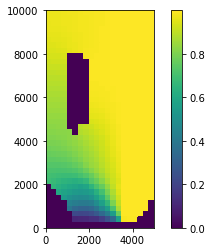

In [18]:
mm = flopy.plot.PlotMapView(model=gwf)
c = mm.plot_array(capture)
plt.colorbar(c)